# Linear regression high dim

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq  
from tqdm import tqdm
from utils import *

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

In [ ]:
def generate_data(
    n_total: int,
    p: int,
    N_model: int,
    std: float = 1.0,
    theta: np.ndarray = None,
    random_state: int = None
):
    rng = np.random.RandomState(random_state)

    # 1) Generate theta if not provided
    if theta is None:
        theta = rng.uniform(low=-1.0, high=1.0, size=p) # * 100
        theta = theta / np.linalg.norm(theta)
    
    # 2) Generate total data
    X_total = rng.normal(size=(n_total, p))
    noise_eval = std * rng.normal(size=n_total)
    Y_total = X_total @ theta + noise_eval

    # 3) Generate predictions
    X_model = rng.normal(size=(N_model, p))
    noise_model = std * rng.normal(size=N_model)
    Y_model = X_model @ theta + noise_model

    model = OLS(Y_model, X_model).fit()
    Y_hat = model.predict(X_total)
    
    return X_total, Y_total, Y_hat, theta, X_total @ theta

100%|██████████| 10/10 [17:43<00:00, 106.37s/it]


len(n_list): 30, len(ppi_width_list): 30


100%|██████████| 10/10 [45:14<00:00, 271.46s/it]


len(n_list): 30, len(ppi_width_list): 30


100%|██████████| 10/10 [1:30:13<00:00, 541.35s/it]


len(n_list): 30, len(ppi_width_list): 30


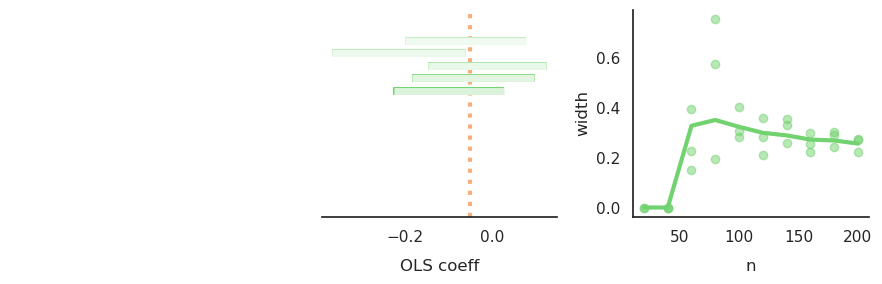

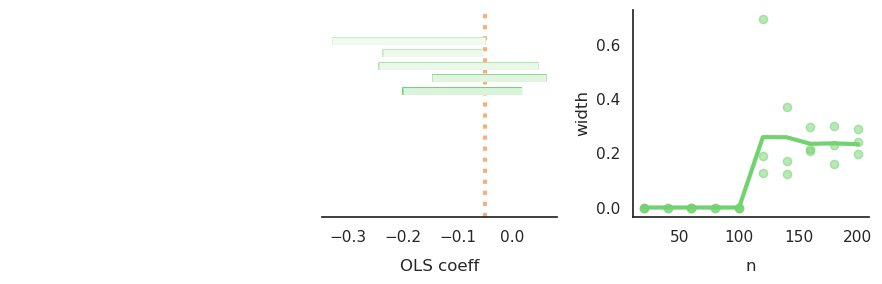

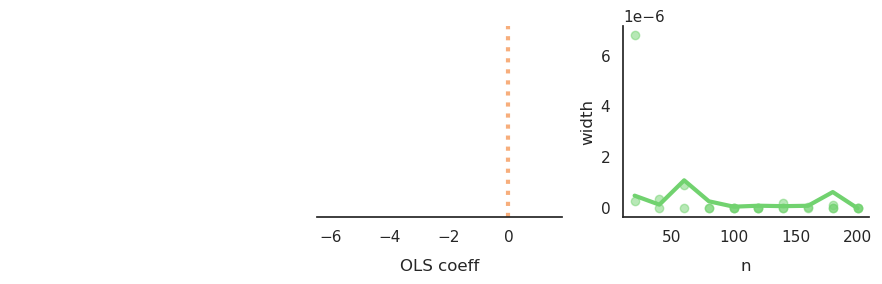

In [ ]:
plist = [2, 5, 10, 20, 50, 100, 200]

for p in plist:
    X_total, Y_total, Yhat_total, theta,_ = generate_data(
        n_total=10000, p=p, N_model=200,
        std=1, theta=None, random_state=42
    )

    alpha = 0.05
    coordinate = 0  # Choose between 0, 1
    n_total = Y_total.shape[0]  # Total number of labeled examples
    ns = np.linspace(20, 200, 10).astype(   
        int
    )  # Test for different numbers of labeled incomes
    num_trials = 100

    # Compute ground truth
    true_theta = OLS(Y_total, exog=X_total).fit().params[coordinate]

    # Run prediction-powered inference and classical inference for many values of n
    results = []
    for i in tqdm(range(ns.shape[0])):
        for j in range(num_trials):
            # Prediction-Powered Inference
            n = ns[i]
            rand_idx = np.random.permutation(n_total)
            _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
            _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
            _Yhat, _Yhat_unlabeled = (
                Yhat_total[rand_idx[:n]],
                Yhat_total[rand_idx[n:]],
            )

            ppi_ci = ppi_ols_ci(
                _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
            )

            # Classical interval
            classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0][coordinate],
                            "upper": ppi_ci[1][coordinate],
                            "trial": j,
                        }
                    ]
                )
            ]
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "Classical",
                            "n": n,
                            "lower": classical_ci[0][coordinate],
                            "upper": classical_ci[1][coordinate],
                            "trial": j,
                        }
                    ]
                )
            ]

    # Imputed CI
    imputed_ci = classical_ols_ci(X_total, Yhat_total, alpha=alpha)
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Imputation",
                    "n": np.nan,
                    "lower": imputed_ci[0][coordinate],
                    "upper": imputed_ci[1][coordinate],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]

    make_plots(
    df,
    "./plots/lr_experiments_p{}.pdf".format(p),
    intervals_xlabel="OLS coeff", plot_classical= False,
    true_theta=true_theta,
)